### Начало

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#папка с библиотеками (для колаба)
base = 'drive/My Drive/GPB'

In [3]:
import sys
import re

import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
!pip install -Uqq ipdb
import ipdb # %pdb on для включения дебаг режима
from matplotlib import style
style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

in_colab = 'google.colab' in sys.modules

if in_colab:
    sys.path.append(base)

def get_drive_path(path):
    in_colab = 'google.colab' in sys.modules
    return '/content/'+base+'/'+re.sub(r'\\','/',path) if in_colab else path

     |████████████████████████████████| 786 kB 5.9 MB/s 
     |████████████████████████████████| 368 kB 47.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.19 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.25.0 which is incompatible.


In [4]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric
!pip install dgl
!pip install torch-geometric-temporal
!pip install memory_profiler

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 2.6 MB 3.9 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.4 MB 4.1 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 926 kB 3.8 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 382 kB 3.9 MB/s 
     |████████████████████████████████| 222 kB 5.3 MB/s 
     |████████████████████████████████| 376 kB 39.1 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-py3-none-any.whl size=388142 sha256=0f823f53ae99a12df1d278cfdc68ab585cefbafb22613e032ed6925c9ea787aa
  Stored in directory: /root/.cache/pip/wheels/55/93/b6/2eeb0465afe89aee74d7a07a606e9770466d7565abd45a99d5
Successfully built torch-

In [5]:
import os
import pickle

import torch
from torch_geometric.data import GraphSAINTRandomWalkSampler, ClusterData, ClusterLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import gnn_package as gnn

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


### Elliptic bitcoin (Static)

In [9]:
# Скачать файлы https://www.kaggle.com/ellipticco/elliptic-data-set
# в папку data/graph/elliptic_bitcoin_dataset

features_path = get_drive_path('data\\graph\\elliptic_bitcoin_dataset\\elliptic_txs_features.csv')
edges_path = get_drive_path('data\\graph\\elliptic_bitcoin_dataset\\elliptic_txs_edgelist.csv')
classes_path = get_drive_path('data\\graph\\elliptic_bitcoin_dataset\\elliptic_txs_classes.csv')

df_features, df_edges = gnn.data.load_and_preprocess_elliptic_dataset(features_path, edges_path, classes_path)

data = gnn.data.create_elliptic_dataset_graph(df_features, df_edges, create_masks=True)

In [10]:
df_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,class
3,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
9,1,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,0.020069,-0.163135,1.696691,2.414968,-0.063200,-0.013282,2.370512,0.001525,-0.172908,0.221419,-0.243300,-0.243452,-0.139732,-0.147416,-0.079747,-0.155559,0.665165,1.037078,-0.139734,-0.147411,-0.079746,-0.155559,0.665251,1.037113,-0.024669,-0.031272,-0.023045,-0.026215,-0.973502,...,-0.124629,0.525309,0.617474,0.317264,-0.121020,-0.188716,-0.032710,-0.047722,-0.048171,-1.373902,-1.356289,-0.301754,-1.404621,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
10,2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,-0.049707,-0.140266,-0.028741,-0.035391,-0.042955,-0.013282,-0.006754,-0.148916,-0.151494,-0.146513,0.887058,0.884557,-0.139721,-0.148905,-0.080147,-0.155653,-0.010763,-0.012107,-0.139723,-0.148901,-0.080147,-0.155653,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.127462,0.003143,0.002426,-0.115680,-0.190199,-0.177836,-0.201578,1.064205,1.063787,-1.373932,-1.356183,-0.301411,-1.404577,-0.975738,-0.975237,-0.168742,-0.445357,-0.409015,-0.427594,-1.015963,-1.016230,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
11,3,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,-0.049707,-0.143847,-0.028741,-0.035391,-0.042955,-0.013282,-0.038424,-0.150266,-0.150457,-0.150661,0.887058,0.884557,-0.139722,-0.148906,-0.080147,-0.155654,-0.010763,-0.012107,-0.139724,-0.148902,-0.080147,-0.155654,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.127462,0.003143,0.002426,-0.107516,-0.190820,-0.180486,-0.200607,1.064205,1.063787,-1.373902,-1.348835,-0.282308,-1.400475,-0.975738,-0.975237,-0.168742,-0.454961,-0.420758,-0.436915,-1.015963,-1.016230,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.216814,-0.587217,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
16,4,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,-0.047227,-0.165719,-2.222844,-2.486106,-0.042955,-0.013282,-0.057321,-0.170460,-0.172121,-0.175463,-1.373657,-1.371460,-0.139732,-0.148846,-0.080069,-0.155603,-2.340501,-2.330877,-0.139734,-0.148841,-0.080069,-0.155603,-2.340378,-2.330626,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,12.256893,-1.512746,-1.934712,-0.123108,-0.198154,-0.186243,-0.212254,1.064205,1.063787,-1.373723,-1.355051,-0.298937,-1.403845,1.342003,1.340733,-0.168742,-0.458162,-0.424672,-0.440022,0.143001,0.142525,-0.968903,-1.943850,-1.059868,-1.678997,0.185597,0.185492,-0.193143,-0.611769,-0

#### GCN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_features = data.num_node_features
num_classes = len(np.unique(data.y.cpu()))

model = gnn.static.GCN(num_features, num_classes)
model.train_(data, epochs=100, device=device, node_mask_attr='train_mask')
pred, f1 = model.evaluate(data, 'test_mask')
f1

array([0.97534729, 0.53505535])

#### GCN_Cluster

In [ ]:
cluster_data = ClusterData(data, num_parts=10, recursive=False, log=False)
batch_loader = ClusterLoader(cluster_data, batch_size=5, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
num_features = data.num_node_features
num_classes = len(np.unique(data.y.cpu()))

model = gnn.static.GCN_Cluster(num_features, num_classes)
model.train_(batch_loader, epochs=100, device=device, node_mask_attr='train_mask')
pred, f1 = model.evaluate(data, 'test_mask')
f1

100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


array([0.97669865, 0.56727273])

#### GCN_SAINT

In [ ]:
data = data.to('cpu')
batch_loader = GraphSAINTRandomWalkSampler(data, batch_size=4100, walk_length=3, num_steps=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
num_features = data.num_node_features
num_classes = len(np.unique(data.y.cpu()))

model = gnn.static.GCN_SAINT(num_features, num_classes)
model.train_(batch_loader, epochs=100, device=device, node_mask_attr='train_mask')
pred, f1 = model.evaluate(data, 'test_mask')
f1

100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


array([0.98258388, 0.70549085])

#### EvolveGCN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_nodes = data.num_nodes
num_features = data.num_node_features
num_classes = len(np.unique(data.y.cpu()))
model = gnn.static.EvolveGCN_H(num_nodes, num_features, num_classes)
model.train_(data, epochs=100, device=device, node_mask_attr='train_mask')
node_mask_attr='train_mask'
getattr(data,node_mask_attr)
pred, f1 = model.evaluate(data, 'test_mask')
f1

array([0.96581031, 0.13658537])

### Elliptic bitcoin (Dynamic)

In [ ]:
graph_list = gnn.data.create_temporal_elliptic_dataset_graph(df_features, df_edges)
train_dataset, test_dataset = gnn.data.temporal_list_split(graph_list, train_ratio=0.75)

num_nodes = df_features.shape[0]
num_features = train_dataset[0].x.shape[1]
num_classes = len(np.unique(train_dataset[0].cpu().y))

# Примерные метрики моделей из статьи EvolveGCN
df_all_metrics_original = pd.DataFrame({'GCN':[0.55, 0.55, 0.5, 0.4, 0.45, 0.65, 0, 0.05, 0, 0, 0.07, 0, 0.07],
                                        'EvolveGCN-H':[0.55, 0.63, 0.5, 0.25, 0.1, 0.5, 0, 0, 0, 0, 0, 0.1, 0.25],
                                        'EvolveGCN-O':[0.6, 0.7, 0.7, 0.55, 0.7, 0.73, 0, 0.05, 0, 0, 0, 0, 0.05],
                                        'GCN-GRU':[0.63, 0.8, 0.7, 0.67, 0.65, 0.79, 0, 0.05, 0, 0, 0.07, 0, 0.06]})

df_all_metrics = pd.DataFrame()

#### GCN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

model = gnn.dynamic.GCN(num_classes, num_features)
model.to(device)
model.train_(train_dataset, 
             epochs=150, 
             device=device, 
             node_mask_attr='node_mask')
preds, metrics = model.evaluate(test_dataset, 'node_mask')
df_metrics = pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])
df_all_metrics['GCN'] = df_metrics['f1 minority class']
print('\n Test:')
df_metrics

 Epoch 10 - f1 minority class mean: 0.3839096346538802
 Epoch 20 - f1 minority class mean: 0.5219416452208908
 Epoch 30 - f1 minority class mean: 0.5541257879293031
 Epoch 40 - f1 minority class mean: 0.5478620810342953
 Epoch 50 - f1 minority class mean: 0.5663436072589904
 Epoch 60 - f1 minority class mean: 0.5679065800090766
 Epoch 70 - f1 minority class mean: 0.5778861351522689
 Epoch 80 - f1 minority class mean: 0.5802544538855827
 Epoch 90 - f1 minority class mean: 0.5953205925606345
 Epoch 100 - f1 minority class mean: 0.6028232043038358
 Epoch 110 - f1 minority class mean: 0.6074377891453135
 Epoch 120 - f1 minority class mean: 0.6169752090497969
 Epoch 130 - f1 minority class mean: 0.630743565034866
 Epoch 140 - f1 minority class mean: 0.6354320346731717
 Epoch 150 - f1 minority class mean: 0.6437483873353854


 Test:


,f1 majority class,f1 minority class
0,0.976378,0.470588
1,0.977625,0.786885
2,0.979366,0.481013
3,0.969222,0.408602
4,0.987625,0.461538
5,0.964271,0.388489
6,0.989339,0.000000
7,0.993935,0.000000
8,0.998069,0.000000
9,0.998661,0.000000


In [ ]:
model_name = 'GCN'
plt.figure(dpi=100)
plt.title(f'{model_name} на Elliptic Bitcoin')
plt.plot(df_all_metrics_original[model_name], label='Реализация IBM')
plt.plot(df_all_metrics[model_name], label='Наша реализация')
plt.xlabel('Номер снапшота')
plt.ylabel('f1 по редкому классу')
plt.xticks(ticks=range(12), labels=range(37, 50))
plt.legend();

#### EvolveGCN

In [ ]:
# Версия -H
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

model = gnn.dynamic.EvolveGCN_H(num_nodes, num_features, num_classes,
                    loss=torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([0.25, 0.75])))
model.to(device)
model.train_(train_dataset,
             epochs=1,
             device=device,
             node_mask_attr='node_mask')
preds, metrics = model.evaluate(test_dataset, 'node_mask')
df_metrics = pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])
df_all_metrics['EvolveGCN-H'] = df_metrics['f1 minority class']
print('\n Test:')
df_metrics

RuntimeError: ignored

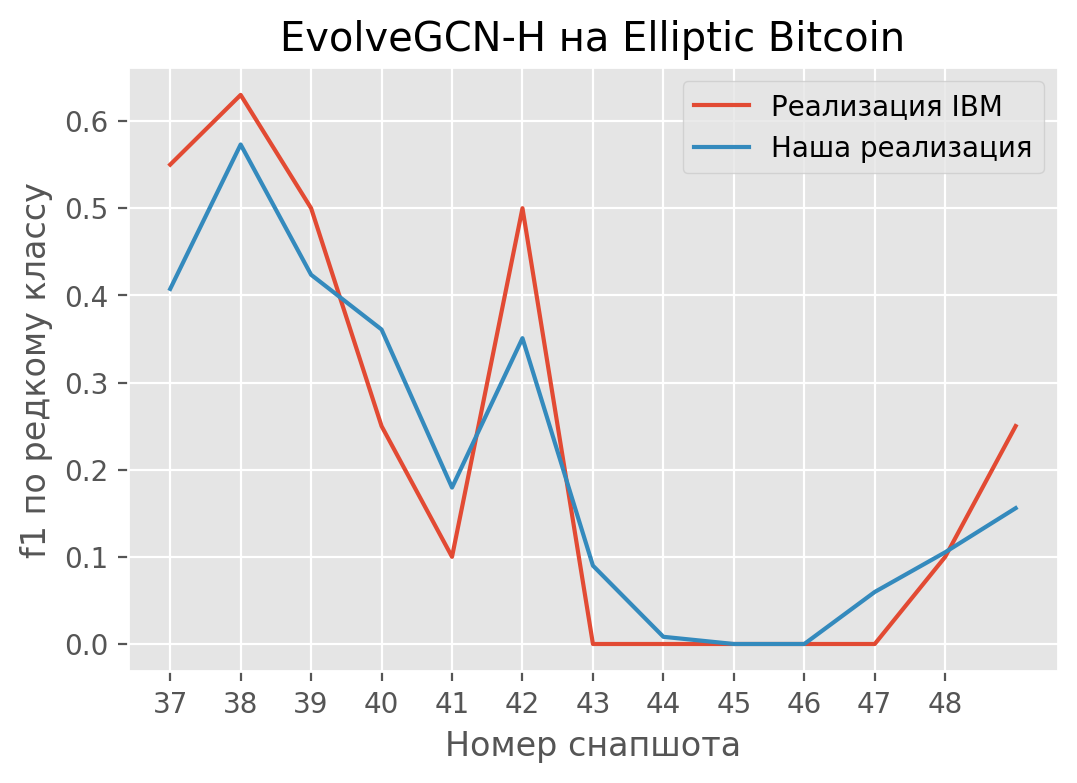

In [ ]:
model_name = 'EvolveGCN-H'
plt.figure(dpi=100)
plt.title(f'{model_name} на Elliptic Bitcoin')
plt.plot(df_all_metrics_original[model_name], label='Реализация IBM')
plt.plot(df_all_metrics[model_name], label='Наша реализация')
plt.xlabel('Номер снапшота')
plt.ylabel('f1 по редкому классу')
plt.xticks(ticks=range(12), labels=range(37, 50))
plt.legend();

In [ ]:
# Версия -O
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = gnn.dynamic.EvolveGCN_O(num_nodes, num_features, num_classes,
                    loss=torch.nn.CrossEntropyLoss(weight=torch.FloatTensor([0.25, 0.75])))
model.to(device)
model.train_(train_dataset,
             epochs=1,
             device=device,
             node_mask_attr='node_mask')
preds, metrics = model.evaluate(test_dataset, 'node_mask')
df_metrics = pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])
df_all_metrics['EvolveGCN-O'] = df_metrics['f1 minority class']
print('\n Test:')
df_metrics



 Test:


,f1 majority class,f1 minority class
0,0.967575,0.0
1,0.944079,0.0
2,0.972139,0.0
3,0.960752,0.0
4,0.984795,0.0
5,0.954319,0.0
6,0.989877,0.0
7,0.996441,0.0
8,0.998069,0.0
9,0.998661,0.0


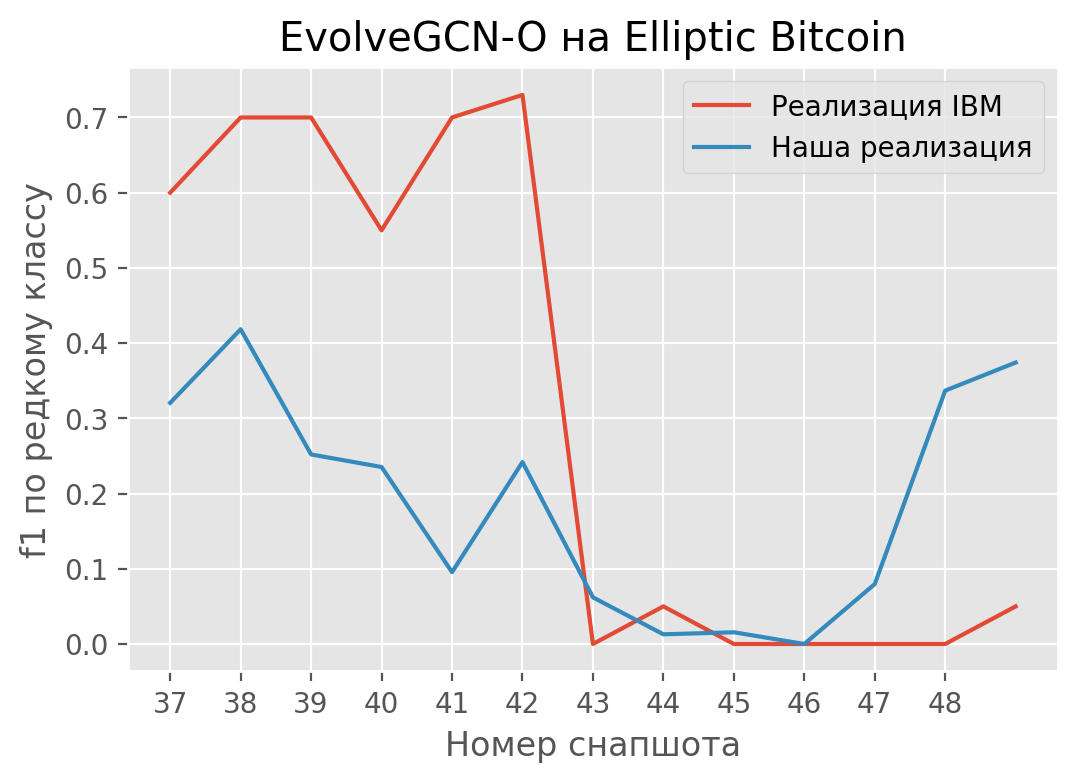

In [ ]:
model_name = 'EvolveGCN-O'
plt.figure(dpi=100)
plt.title(f'{model_name} на Elliptic Bitcoin')
plt.plot(df_all_metrics_original[model_name], label='Реализация IBM')
plt.plot(df_all_metrics[model_name], label='Наша реализация')
plt.xlabel('Номер снапшота')
plt.ylabel('f1 по редкому классу')
plt.xticks(ticks=range(12), labels=range(37, 50))
plt.legend();

#### GCN-GRU

In [ ]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

model = gnn.dynamic.GCN_GRU(num_features, num_classes)
model.to(device)
model.train_(train_dataset,
             epochs=1,
             device=device,
             node_mask_attr='node_mask')
preds, metrics = model.evaluate(test_dataset, 'node_mask')
print('\n Test:')
pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])

AttributeError: ignored

#### GCN_Cluster

In [ ]:
train_batch_loader_list = []
for data in train_dataset:
    cluster_data = ClusterData(data, num_parts=3, recursive=False, log=False)
    train_batch_loader_list.append(ClusterLoader(cluster_data, batch_size=1, shuffle=False))
test_batch_loader_list = []
for data in test_dataset:
    cluster_data = ClusterData(data, num_parts=3, recursive=False, log=False)
    test_batch_loader_list.append(ClusterLoader(cluster_data, batch_size=1, shuffle=False))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

model = gnn.dynamic.GCN_Cluster(num_classes, num_features)
model.to(device)
model.train_(train_batch_loader_list,
             epochs=1,
             device=device,
             node_mask_attr='node_mask')
preds, metrics = model.evaluate(test_batch_loader_list, 'node_mask')
print('\n Test:')
pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])



 Test:


,f1 majority class,f1 minority class
0,0.876833,0.263158
1,0.870067,0.448980
2,0.874786,0.309148
3,0.793243,0.235000
4,0.771014,0.112360
5,0.755016,0.256410
6,0.772135,0.027778
7,0.579929,0.004779
8,0.820921,0.006309
9,0.799358,0.000000


#### GCN_SAINT

In [ ]:
train_batch_loader_list = []
for data in train_dataset:
    data = data.to('cpu')
    train_batch_loader_list.append(GraphSAINTRandomWalkSampler(data, batch_size=100, walk_length=10, num_steps=10))
test_batch_loader_list = []
for data in test_dataset:
    data = data.to('cpu')
    test_batch_loader_list.append(GraphSAINTRandomWalkSampler(data, batch_size=100, walk_length=10, num_steps=10))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

model = gnn.dynamic.GCN_SAINT(num_features, num_classes)
model.to(device)
model.train_(train_batch_loader_list,
             epochs=1,
             device=device,
             node_mask_attr='node_mask',
             evaluate=False)
preds, metrics = model.evaluate(test_batch_loader_list, 'node_mask')
print('\n Test:')
pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])

RuntimeError: ignored

#### GCN-GRU_Cluster

In [ ]:
from torch_geometric.data import ClusterData, ClusterLoader

train_batch_loader_list = []
for data in train_dataset:
    cluster_data = ClusterData(data, num_parts=3, recursive=False, log=False)
    train_batch_loader_list.append(ClusterLoader(cluster_data, batch_size=1, shuffle=False))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

model = GCN_GRU_Cluster(num_features, num_classes)
model.to(device)
model.train_(train_batch_loader_list,
             epochs=100,
             device=device,
             node_mask_attr='node_mask',
             evaluate=False)
preds, metrics = model.evaluate(test_dataset, 'node_mask')
print('\n Test:')
pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])


100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


,f1 majority class,f1 minority class
0,0.969617,0.410256
1,0.977470,0.800000
2,0.986653,0.779661
3,0.967447,0.558140
4,0.983881,0.557377
5,0.961706,0.600000
6,0.981193,0.000000
7,0.968921,0.000000
8,0.983847,0.000000
9,0.995973,0.000000


#### GCN-GRU_SAINT

In [ ]:
train_batch_loader_list = [
    GraphSAINTRandomWalkSampler(data, batch_size=500, walk_length=3, num_steps=5) for data in train_dataset]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

model = GCN_GRU_SAINT(num_features, num_classes)
model.to(device)
model.train_(train_batch_loader_list,
             epochs=1,
             device=device,
             node_mask_attr='node_mask',
             evaluate=False)
preds, metrics = model.evaluate(test_dataset, 'node_mask')
pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])

  0%|          | 0/1 [00:00<?, ?it/s]

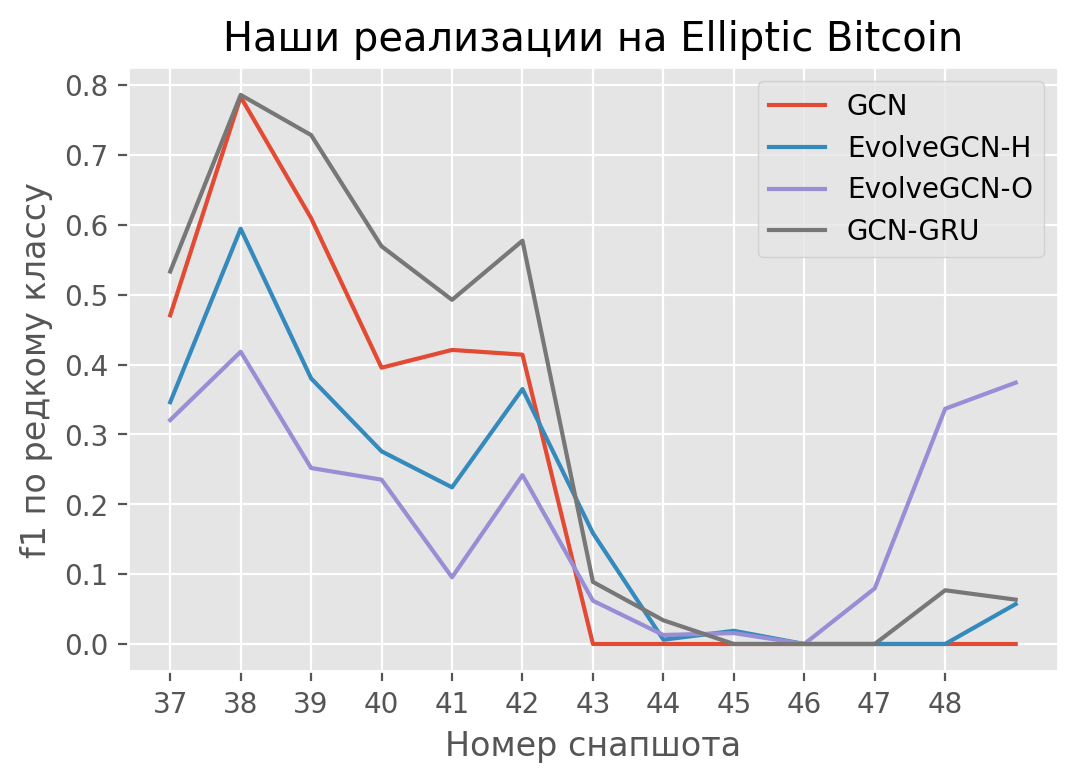

In [ ]:
plt.figure(dpi=100)
for model_name in df_all_metrics:
    plt.plot(df_all_metrics[model_name], label=model_name)

plt.title(f'Наши реализации на Elliptic Bitcoin')
plt.xlabel('Номер снапшота')
plt.ylabel('f1 по редкому классу')
plt.xticks(ticks=range(12), labels=range(37, 50))
plt.legend();

### Synthetic датасет транзакций (static)

In [ ]:
def default_time_check(default_time, last_time):
    '''
    Проверка на то, считается ли дефолт компании действующим
    last_time - последнее время, имеющееся в транзакциях
    '''
    # Дефолт считается активным если он произошел в месяце, который имеется в транзакциях или произошел раньше
    default_time = pd.to_datetime(default_time)
    return (last_time <= default_time 
            or (last_time.month == default_time.month and last_time.year == default_time.year))

def create_graph(features, transactions):
    x = torch.tensor(features[['agent','balance']].values,
                     dtype=torch.float)
    # Таргет - наличие дефолта
    
    last_time = transactions['time'].iloc[-1]
    
    y = np.array([1 if default_time != 'None' and default_time_check(default_time, last_time)
                  else 0
                  for default_time in features['default time']])
    y = torch.tensor(y,
                     dtype=torch.long)

    edge_index = torch.tensor(transactions[['from','to']].values.T.astype('int'),
                              dtype=torch.long)

    edge_attr = torch.tensor(transactions[['class','sum']].values,
                             dtype=torch.float)

    return Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr)

class FeatureExtractor:
    '''
    Фичи для узлов
    '''
    def fit(self, companies_attrs):
        self.inn_encoder = LabelEncoder()
        self.agent_encoder = LabelEncoder()
        self.inn_encoder.fit(companies_attrs['inn'])
        self.agent_encoder.fit(companies_attrs['agent'])
    
    def transform(self, companies_attrs):
        features = companies_attrs[['inn','agent','balance','default time']]
        features['inn'] = self.inn_encoder.transform(features['inn'])
        features['agent'] = self.agent_encoder.transform(features['agent'])
        features = features.sort_values('inn')
        return features
    
    def fit_transform(self, companies_attrs):
        self.fit(companies_attrs)
        return self.transform(companies_attrs)

# Фичи в графе
with open(get_drive_path('data\\graph\\companies_attrs.pkl'), 'rb') as f:
    companies_attrs = pickle.load(f)[0]
with open(get_drive_path('data\\graph\\transactions.pkl'), 'rb') as f:
    transactions_orig = pickle.load(f)

feature_extractor = FeatureExtractor()
features = feature_extractor.fit_transform(companies_attrs)

#transactions_orig = pd.read_csv(get_drive_path('data\\graph\\transactions.txt'),
#                                sep='\t')
transactions = transactions_orig.copy()

transactions['from'] = transactions['from'].astype(str)
transactions['to'] = transactions['to'].astype(str)
transactions['from'] = feature_extractor.inn_encoder.transform(transactions['from'])
transactions['to'] = feature_extractor.inn_encoder.transform(transactions['to'])

cls_encoder = LabelEncoder()
transactions['class'] = cls_encoder.fit_transform(transactions['class'])

transactions['time'] = pd.to_datetime(transactions['time'])

In [ ]:
data = create_graph(features, transactions)

num_nodes = data.x.shape[0]
nodes = np.arange(num_nodes)
train_nodes, test_nodes = train_test_split(nodes, test_size=0.2, stratify=data.y, random_state=42)
data.train_mask = [node in train_nodes for node in nodes]
data.test_mask = np.logical_not(data.train_mask)
train_nodes, val_nodes = train_test_split(train_nodes, test_size=0.2, stratify=data.y[data.train_mask], random_state=42)
data.train_mask = [node in train_nodes for node in nodes]
data.val_mask = np.array([node in val_nodes for node in nodes])

num_features = data.num_node_features
num_classes = len(np.unique(data.y.cpu()))

#### GCN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(num_features, num_classes,
            loss=nn.CrossEntropyLoss(weight=torch.FloatTensor([0.25, 0.75])))
model.train_(data, train_nodes, epochs=500, device=device)
pred, f1 = model.evaluate(data, 'test_mask')
f1

100%|██████████| 500/500 [00:01<00:00, 324.25it/s]


array([0.97326203, 0.        ])

### Synthetic датасет транзакций (dynamic)

In [ ]:
transactions = transactions.sort_values('time')

split_transactions = transactions.groupby(pd.Grouper(key='time', freq='M'))

with open(get_drive_path('data\\graph\\companies_attrs.pkl'), 'rb') as f:
    companies_attrs_list = pickle.load(f)

graph_list = []
for companies_attrs,transactions_group in zip(companies_attrs_list, split_transactions):
    transactions_ = transactions_group[1]
    features_ = feature_extractor.transform(companies_attrs)
    
    graph_list.append(create_graph(features_, transactions_))

edge_index_list = [graph.edge_index.numpy() for graph in graph_list]
edge_weights_list = [graph.edge_attr[:,1].numpy() for graph in graph_list] # Суммы транзакций
features_list = [graph.x.numpy() for graph in graph_list]
targets_list = [graph.y.numpy() for graph in graph_list]

dataset = DynamicGraphTemporalSignal(edge_index_list, edge_weights_list, features_list, targets_list)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.75)

num_classes = len(np.unique(train_dataset.targets[0]))
num_features = dataset.features[0].shape[1]
num_nodes = dataset.features[0].shape[0]

#### GCN

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
model = GCN_Dynamic(num_classes, num_features,
                    loss=nn.CrossEntropyLoss(weight=torch.FloatTensor([0.25, 0.75])))
model.to(device)
model.train_(train_dataset, epochs=100, device=device, node_mask_attr=None)
preds, metrics = model.evaluate(test_dataset, None)
df_metrics = pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])
df_metrics

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
 19%|█▉        | 19/100 [00:00<00:01, 80.48it/s]

 Epoch 10 - f1 minority class mean: 0.0
 Epoch 20 - f1 minority class mean: 1.0


 42%|████▏     | 42/100 [00:00<00:00, 73.47it/s]

 Epoch 30 - f1 minority class mean: 0.0
 Epoch 40 - f1 minority class mean: 0.0


 60%|██████    | 60/100 [00:00<00:00, 74.77it/s]

 Epoch 50 - f1 minority class mean: 1.0
 Epoch 60 - f1 minority class mean: 0.0


 85%|████████▌ | 85/100 [00:01<00:00, 74.07it/s]

 Epoch 70 - f1 minority class mean: 0.0
 Epoch 80 - f1 minority class mean: 0.0


100%|██████████| 100/100 [00:01<00:00, 75.37it/s]

 Epoch 90 - f1 minority class mean: 0.0
 Epoch 100 - f1 minority class mean: 0.0


,f1 majority class,f1 minority class
0,0.920598,0.241758
1,0.932571,0.305882


#### GCN_Cluster

In [ ]:
train_batch_loader_list = []
for data in train_dataset:
    cluster_data = ClusterData(data, num_parts=3, recursive=False, log=False)
    train_batch_loader_list.append(ClusterLoader(cluster_data, batch_size=1, shuffle=False))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

model = GCN_DynamicCluster(num_features, num_classes)
model.to(device)
model.train_(train_batch_loader_list,
             epochs=100,
             device=device,
             node_mask_attr=None)
preds, metrics = model.evaluate(test_dataset, None)
pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])

100%|██████████| 100/100 [00:04<00:00, 23.48it/s]


,f1 majority class,f1 minority class
0,0.920598,0.241758
1,0.932571,0.305882


#### GCN_SAINT

In [ ]:
train_batch_loader_list = [
    GraphSAINTRandomWalkSampler(data, batch_size=100, walk_length=10, num_steps=10) for data in train_dataset]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

model = GCN_DynamicSAINT(num_features=num_features, num_classes=num_classes)
model.to(device)
model.train_(train_batch_loader_list,
             epochs=100,
             device=device,
             node_mask_attr=None)
#preds, metrics = model.evaluate(test_dataset, None)
#pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])

  0%|          | 0/100 [00:00<?, ?it/s]

#### GCN-GRU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

model = GCN_GRU(num_features, num_classes,
                loss=nn.CrossEntropyLoss(weight=torch.FloatTensor([0.25, 0.75])))
model.to(device)
model.train_(train_dataset,
             epochs=100,
             device=device
             node_mask_attr=None)
preds, metrics = model.evaluate(test_dataset, None)
pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])

  8%|▊         | 8/100 [00:00<00:05, 16.57it/s]/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
 12%|█▏        | 12/100 [00:00<00:05, 15.11it/s]

 Epoch 10 - f1 minority class mean: 0.0


 22%|██▏       | 22/100 [00:01<00:05, 15.14it/s]

 Epoch 20 - f1 minority class mean: 0.0


 32%|███▏      | 32/100 [00:02<00:04, 14.74it/s]

 Epoch 30 - f1 minority class mean: 0.0


 42%|████▏     | 42/100 [00:02<00:03, 14.64it/s]

 Epoch 40 - f1 minority class mean: 0.0


 52%|█████▏    | 52/100 [00:03<00:03, 14.84it/s]

 Epoch 50 - f1 minority class mean: 0.2


 62%|██████▏   | 62/100 [00:04<00:02, 14.69it/s]

 Epoch 60 - f1 minority class mean: 0.2


 72%|███████▏  | 72/100 [00:04<00:01, 14.47it/s]

 Epoch 70 - f1 minority class mean: 0.0


 82%|████████▏ | 82/100 [00:05<00:01, 14.76it/s]

 Epoch 80 - f1 minority class mean: 0.0


 92%|█████████▏| 92/100 [00:06<00:00, 14.57it/s]

 Epoch 90 - f1 minority class mean: 0.0


100%|██████████| 100/100 [00:06<00:00, 15.01it/s]


 Epoch 100 - f1 minority class mean: 0.0


,f1 majority class,f1 minority class
0,0.805627,0.146067
1,0.812739,0.160000


#### GCN-GRU_Cluster

In [ ]:
train_batch_loader_list = []
for data in train_dataset:
    cluster_data = ClusterData(data, num_parts=3, recursive=False, log=False)
    train_batch_loader_list.append(ClusterLoader(cluster_data, batch_size=1, shuffle=False))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

model = GCN_GRU_Cluster(num_features, num_classes,
                        loss=nn.CrossEntropyLoss(weight=torch.FloatTensor([0.25, 0.75])))
model.to(device)
model.train_(train_batch_loader_list,
             epochs=100,
             device=device,
             node_mask_attr=None)
preds, metrics = model.evaluate(test_dataset, None)
pd.DataFrame(metrics, columns=['f1 majority class', 'f1 minority class'])

100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


,f1 majority class,f1 minority class
0,0.886256,0.172414
1,0.876647,0.176000


In [ ]:
import os 
os.chdir('/content/drive/MyDrive/LiteralE-master')
!python -m memory_profiler temp1.py

Using backend: pytorch


 Test:
hui
    f1 majority class  f1 minority class
0            0.967575                0.0
1            0.944079                0.0
2            0.972139                0.0
3            0.960752                0.0
4            0.984795                0.0
5            0.954319                0.0
6            0.989877                0.0
7            0.996441                0.0
8            0.998069                0.0
9            0.998661                0.0
10           0.985359                0.0
11           0.964885                0.0
12           0.931034                0.0
Filename: temp1.py

Line #    Mem usage    Increment  Occurences   Line Contents
   111    658.8 MiB    658.8 MiB           1   @profile
   112                                         def main_GCN_GRU():
   113    658.8 MiB      0.0 MiB           1     device = 'cpu'
   114                                           # Скачать файлы https://www.kaggle.com/ellipticco/elliptic-data-set
   11